# Import Library

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [28]:
import pyspark

In [29]:
import yfinance as yahooFinance

In [30]:
from pandasql import sqldf

# Load Data

In [31]:
BBCA = yahooFinance.Ticker("BBCA")
df =  pd.DataFrame(BBCA.history(period="3y"))

In [32]:
q = """
WITH raw AS (
    SELECT
        date,
        close,
        LAG(close, 1) OVER (ORDER BY date) AS min_1_close,
        LAG(close, 2) OVER (ORDER BY date) AS min_2_close,
        LAG(close, 3) OVER (ORDER BY date) AS min_3_close,
        LAG(close, 4) OVER (ORDER BY date) AS min_4_close
    FROM
        df
),
raw_plus_trend AS (
    SELECT
        date,
        close,
        min_1_close,
        CASE WHEN min_1_close - min_2_close > 0 THEN 1 ELSE -1 END AS min_1_trend,
        CASE WHEN min_2_close - min_3_close > 0 THEN 1 ELSE -1 END AS min_2_trend,
        CASE WHEN min_3_close - min_4_close > 0 THEN 1 ELSE -1 END AS min_3_trend
    FROM
        raw
),
train_data AS (
    SELECT
        date,
        close,
        min_1_close AS day_prev_close,
        CASE WHEN min_1_trend + min_2_trend + min_3_trend > 0 THEN 1 ELSE -1 END AS trend_3_day
    FROM
        raw_plus_trend
    ORDER BY
        date ASC
)
SELECT
    *
FROM
    train_data
"""
df = sqldf(q,globals())

In [33]:
print(type(df))
df.dropna(inplace=True)
df.head()

<class 'pandas.core.frame.DataFrame'>


,date,close,day_prev_close,trend_3_day
1,2020-10-01 00:00:00.000000,44.518089,44.276752,-1
2,2020-10-02 00:00:00.000000,44.480957,44.518089,-1
3,2020-10-05 00:00:00.000000,45.279240,44.480957,-1
4,2020-10-06 00:00:00.000000,44.685177,45.279240,1
5,2020-10-07 00:00:00.000000,45.372063,44.685177,-1


In [34]:
df['date'] = pd.to_datetime(df['date'])

<Axes: xlabel='date'>

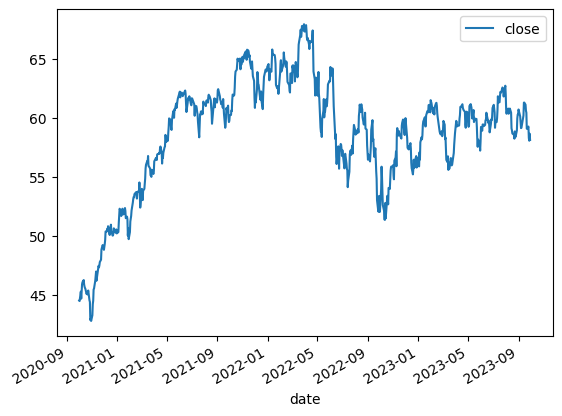

In [35]:
df.plot(x='date', y='close')

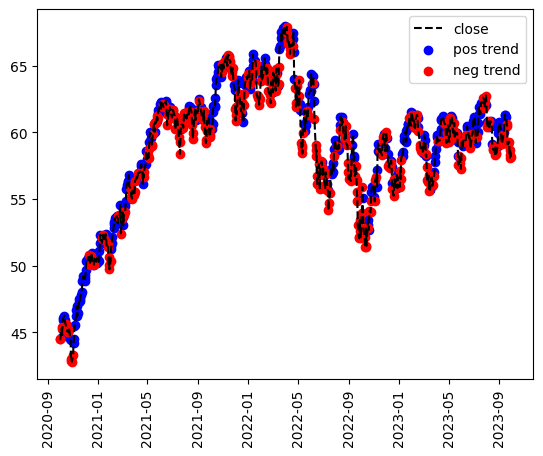

In [36]:
start_date = df['date'].min()
end_date = df['date'].max()

plt.plot(
    'date', 'close', 'k--',
    data = (
        df.loc[pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='b', label='pos trend', 
    data = (
        df.loc[df.trend_3_day == 1 & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.scatter(
    'date', 'close', color='r', label='neg trend',
    data = (
        df.loc[(df.trend_3_day == -1) & pd.to_datetime(df.date).between(start_date, end_date)]
    )
)

plt.legend()
plt.xticks(rotation = 90);

In [37]:
df.shape

(754, 4)

# Model Development

In [38]:
features = ['day_prev_close', 'trend_3_day']
target = 'close'
x = df[features]
y = df[target]

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = x.loc[:527],x.loc[527:],y.loc[:527],y.loc[527:]

In [40]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def calculate_explained_variance(y_true, y_pred):
    explained_variance = 1 - (np.var(y_true - y_pred) / np.var(y_true))
    return explained_variance

def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    test_r2 = r2_score(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    explained_variance = calculate_explained_variance(y_test, y_pred)
    
    adjusted_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1)
    overfitting_indication = train_r2 - test_r2
    
    return test_r2, train_r2, mae, mse, rmse, explained_variance, adjusted_r2, overfitting_indication

# Linear Regression
lr = LinearRegression()
lr_test_r2, lr_train_r2, lr_mae, lr_mse, lr_rmse, lr_explained_variance, lr_adjusted_r2, lr_overfitting = evaluate_model(lr, x_train, y_train, x_test, y_test)

# Lasso
ls = Lasso()
ls_test_r2, ls_train_r2, ls_mae, ls_mse, ls_rmse, ls_explained_variance, ls_adjusted_r2, ls_overfitting = evaluate_model(ls, x_train, y_train, x_test, y_test)

# Ridge
rg = Ridge()
rg_test_r2, rg_train_r2, rg_mae, rg_mse, rg_rmse, rg_explained_variance, rg_adjusted_r2, rg_overfitting = evaluate_model(rg, x_train, y_train, x_test, y_test)

# Decision Tree
dt = DecisionTreeRegressor()
dt_test_r2, dt_train_r2, dt_mae, dt_mse, dt_rmse, dt_explained_variance, dt_adjusted_r2, dt_overfitting = evaluate_model(dt, x_train, y_train, x_test, y_test)

# Random Forest
rf = RandomForestRegressor()
rf_test_r2, rf_train_r2, rf_mae, rf_mse, rf_rmse, rf_explained_variance, rf_adjusted_r2, rf_overfitting = evaluate_model(rf, x_train, y_train, x_test, y_test)

# AdaBoost
ab = AdaBoostRegressor()
ab_test_r2, ab_train_r2, ab_mae, ab_mse, ab_rmse, ab_explained_variance, ab_adjusted_r2, ab_overfitting = evaluate_model(ab, x_train, y_train, x_test, y_test)

# XGBoost
xgb = XGBRegressor()
xgb_test_r2, xgb_train_r2, xgb_mae, xgb_mse, xgb_rmse, xgb_explained_variance, xgb_adjusted_r2, xgb_overfitting = evaluate_model(xgb, x_train, y_train, x_test, y_test)

# LightGBM
lgbm = LGBMRegressor()
lgbm_test_r2, lgbm_train_r2, lgbm_mae, lgbm_mse, lgbm_rmse, lgbm_explained_variance, lgbm_adjusted_r2, lgbm_overfitting = evaluate_model(lgbm, x_train, y_train, x_test, y_test)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 527, number of used features: 2
[LightGBM] [Info] Start training from score 58.398834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [41]:
data = {
    'model': ['Linear', 'Lasso', 'Ridge', 'Decision Tree', 'Random Forest', 'AdaBoost', 'XGBoost', 'LightGBM'],
    'score': [lr_test_r2, ls_test_r2, rg_test_r2, dt_test_r2, rf_test_r2, ab_test_r2, xgb_test_r2, lgbm_test_r2],
    'MAE': [lr_mae, ls_mae, rg_mae, dt_mae, rf_mae, ab_mae, xgb_mae, lgbm_mae],
    'MSE': [lr_mse, ls_mse, rg_mse, dt_mse, rf_mse, ab_mse, xgb_mse, lgbm_mse],
    'RMSE': [lr_rmse, ls_rmse, rg_rmse, dt_rmse, rf_rmse, ab_rmse, xgb_rmse, lgbm_rmse],
    'Variance Score': [
        calculate_explained_variance(y_test, lr.predict(x_test)),
        calculate_explained_variance(y_test, ls.predict(x_test)),
        calculate_explained_variance(y_test, rg.predict(x_test)),
        calculate_explained_variance(y_test, dt.predict(x_test)),
        calculate_explained_variance(y_test, rf.predict(x_test)),
        calculate_explained_variance(y_test, ab.predict(x_test)),
        calculate_explained_variance(y_test, xgb.predict(x_test)),
        calculate_explained_variance(y_test, lgbm.predict(x_test))
    ],
    'Indication Overfitting': [lr_overfitting, ls_overfitting, rg_overfitting, dt_overfitting, rf_overfitting, ab_overfitting, xgb_overfitting, lgbm_overfitting]
}

df_eval = pd.DataFrame(data)
df_eval.sort_values(by='Variance Score',ascending=False)


,model,score,MAE,MSE,RMSE,Variance Score,Indication Overfitting
1,Lasso,0.874460,0.465920,0.360641,0.600534,0.874677,0.111435
2,Ridge,0.872141,0.468168,0.367303,0.606055,0.872142,0.114643
0,Linear,0.872135,0.468178,0.367322,0.606071,0.872135,0.114650
5,AdaBoost,0.853096,0.511726,0.422016,0.649627,0.854882,0.132769
7,LightGBM,0.853080,0.508731,0.422061,0.649662,0.853509,0.136158
4,Random Forest,0.803136,0.595792,0.565536,0.752021,0.803267,0.194004
6,XGBoost,0.791203,0.611168,0.599815,0.774477,0.791207,0.207164
3,Decision Tree,0.712784,0.715575,0.825094,0.908347,0.712826,0.286976


Lasso is the best for this case

In [42]:
y_true = y_test
y_pred = ls.predict(x_test)
df_pred = pd.DataFrame(data={'date':df['date'].loc[527:],'true_data':y_test,'pred_data':y_pred})

In [43]:
df_pred

,date,true_data,pred_data
527,2022-11-02,55.153175,56.129205
528,2022-11-03,54.812302,55.307750
529,2022-11-04,56.390057,54.981033
530,2022-11-07,56.662750,56.493263
531,2022-11-08,57.169186,56.754632
...,...,...,...
750,2023-09-25,59.290001,59.081077
751,2023-09-26,58.310001,59.272772
752,2023-09-27,58.090000,58.333472
753,2023-09-28,58.680000,58.122607


<Axes: >

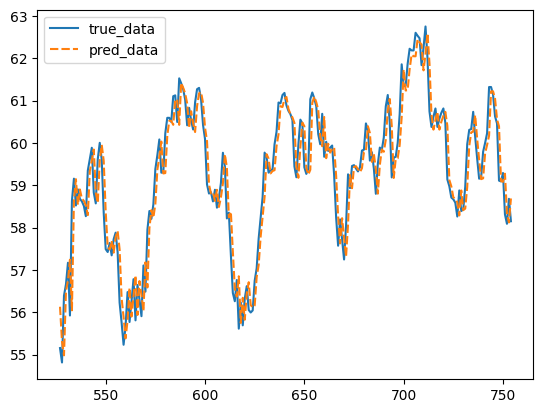

In [44]:
sns.lineplot(data=df_pred)

<Axes: xlabel='true_data', ylabel='pred_data'>

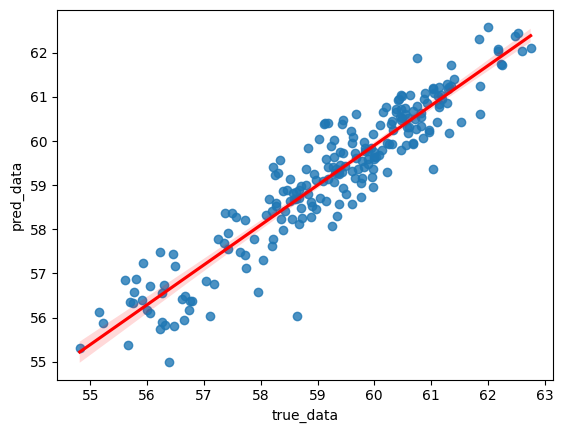

In [45]:
sns.regplot(x=df_pred['true_data'],y=df_pred['pred_data'],line_kws = {"color": "red"})

## Dynamic Testing

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    y_pred_train = model.predict(x_train)
    
    test_r2 = r2_score(y_test, y_pred)
    train_r2 = r2_score(y_train, y_pred_train)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    explained_variance = calculate_explained_variance(y_test, y_pred)
    
    adjusted_r2 = 1 - (1 - test_r2) * (len(y_test) - 1) / (len(y_test) - x_train.shape[1] - 1)
    overfitting_indication = train_r2 - test_r2
    
    return model,test_r2, train_r2, mae, mse, rmse, explained_variance, adjusted_r2, overfitting_indication
# Define a dictionary of models
models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor()
}

# Initialize empty lists to store performance metrics
model_names = []
test_r2_scores = []
mae_scores = []
mse_scores = []
rmse_scores = []
variance_scores = []
overfitting_scores = []

# Loop through the models and evaluate each one
for model_name, model in models.items():
    # Fit the model on the training data
    model.fit(x_train, y_train)
    
    # Iterate through the test dataset for dynamic updates
    predicted_close_values = []
    trend_3_day_values = []

    for index, row in x_test.iterrows():
        # Make a prediction for the current data point
        features_for_prediction = np.array([row['day_prev_close'], row['trend_3_day']]).reshape(1, -1)
        y_pred = model.predict(features_for_prediction)

        # Append the predicted 'close' value to the list
        predicted_close_values.append(y_pred[0])

        # Calculate the 'trend_3_day' based on the predicted 'close' value
        trend_3_day = 1 if y_pred > row['day_prev_close'] else -1
        trend_3_day_values.append(trend_3_day)

        # Update the 'day_prev_close' value for the next iteration
        row['day_prev_close'] = y_pred[0]

    # Assign the predicted values to the test dataset
    x_test['day_prev_close'] = predicted_close_values
    x_test['trend_3_day'] = trend_3_day_values

    # Evaluate the model on the updated test dataset
    model,test_r2, train_r2, mae, mse, rmse, explained_variance, adjusted_r2, overfitting_indication = evaluate_model(model, x_train, y_train, x_test, y_test)
    
    # Append the results to the lists
    model_names.append(model_name)
    test_r2_scores.append(test_r2)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    variance_scores.append(explained_variance)
    overfitting_scores.append(overfitting_indication)

# Create a DataFrame to store the results
data = {
    'model': model_names,
    'score': test_r2_scores,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'Variance Score': variance_scores,
    'Indication Overfitting': overfitting_scores
}

df_eval = pd.DataFrame(data)

# Sort the DataFrame by Variance Score in descending order
df_eval = df_eval.sort_values(by='Variance Score', ascending=False)

# Display the sorted DataFrame
print(df_eval)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 527, number of used features: 2
[LightGBM] [Info] Start training from score 58.398834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [48]:
df_eval 

,model,score,MAE,MSE,RMSE,Variance Score,Indication Overfitting
2,Ridge,0.875515,0.462164,0.357611,0.598006,0.875550,0.111269
1,Lasso,0.874503,0.466688,0.360518,0.600432,0.874680,0.111392
0,Linear,0.873770,0.465501,0.362625,0.602183,0.873860,0.113015
4,Random Forest,0.641910,0.798418,1.028695,1.014246,0.647025,0.355417
5,AdaBoost,0.623295,0.811649,1.082171,1.040274,0.639074,0.362323
7,LightGBM,0.581933,0.879211,1.200991,1.095897,0.581937,0.407304
3,Decision Tree,0.541959,0.899676,1.315825,1.147094,0.547222,0.457801
6,XGBoost,0.514188,0.933459,1.395605,1.181357,0.536177,0.484180


In [67]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# Train your model as you have done
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = x.loc[:527],x.loc[527:],y.loc[:527],y.loc[527:]
lr = Ridge()
lr.fit(x_train, y_train)

# Initialize an empty list to store predicted 'close' values
predicted_close_values = []

# Initialize an empty list to store 'trend_3_day' values
trend_3_day_values = []

# Iterate through the test dataset
for index, row in x_test.iterrows():
    # Make a prediction for the current data point
    # Provide both 'day_prev_close' and 'trend_3_day' as input features
    features_for_prediction = np.array([row['day_prev_close'], row['trend_3_day']]).reshape(1, -1)
    y_pred = lr.predict(features_for_prediction)

    # Append the predicted 'close' value to the list
    predicted_close_values.append(y_pred[0])

    # Calculate the 'trend_3_day' based on the predicted 'close' value
    trend_3_day = 1 if y_pred > row['day_prev_close'] else -1
    trend_3_day_values.append(trend_3_day)

    # Update the 'day_prev_close' value for the next iteration
    row['day_prev_close'] = y_pred[0]

# Assign the predicted values to the test dataset
x_test['day_prev_close'] = predicted_close_values
x_test['trend_3_day'] = trend_3_day_values

# Now, x_test contains the updated 'day_prev_close' and 'trend_3_day' features based on dynamic predictions

# Evaluate your model on the updated test dataset
def calculate_explained_variance(y_true, y_pred):
    explained_variance = 1 - (np.var(y_true - y_pred) / np.var(y_true))
    return explained_variance

def evaluate_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    explained_variance = calculate_explained_variance(y_test, y_pred)
    
    r2 = r2_score(y_test, y_pred)
    
    return r2, mae, mse, rmse, explained_variance

# Evaluate your model on the updated test dataset
test_r2, test_mae, test_mse, test_rmse, test_explained_variance = evaluate_model(lr, x_test, y_test)

# Print the evaluation metrics
print("Test R^2 Score:", test_r2)
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test Explained Variance:", test_explained_variance)


Test R^2 Score: 0.8730621021971622
Test MAE: 0.4664194624520169
Test MSE: 0.364657562306756
Test RMSE: 0.6038688287258716
Test Explained Variance: 0.8730922763644303


In [51]:
y_true = y_test
y_pred = ls.predict(x_test)
df_pred = pd.DataFrame(data={'date':df['date'].loc[527:],'true_data':y_test,'pred_data':y_pred})

In [52]:
df_pred

,date,true_data,pred_data
527,2022-11-02,55.153175,56.738381
528,2022-11-03,54.812302,54.598665
529,2022-11-04,56.390057,54.765730
530,2022-11-07,56.662750,56.809326
531,2022-11-08,57.169186,57.155815
...,...,...,...
750,2023-09-25,59.290001,60.219554
751,2023-09-26,58.310001,60.145920
752,2023-09-27,58.090000,58.686142
753,2023-09-28,58.680000,58.915097


<Axes: >

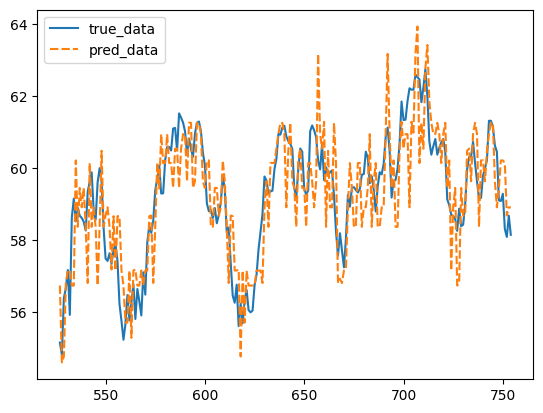

In [53]:
sns.lineplot(data=df_pred)

In [74]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

# Load your data and perform the necessary preprocessing (as you have done before)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = x.loc[:527],x.loc[527:],y.loc[:527],y.loc[527:]

# Train the Ridge model on your historical data
ridge = Ridge()
ridge.fit(x_train, y_train)

# Define the number of weekdays to predict (e.g., 10 weekdays for two weeks)
num_weekdays_to_predict = 10

# Create a DataFrame for future dates
# You can adjust the start date (last date + 1 day) and end date (last date + num_weekdays_to_predict weekdays) as needed
start_date = '2023-09-30'  # Last date + 1 day
end_date = pd.date_range(start=start_date, periods=num_weekdays_to_predict, freq='B')[-1]  # Last date + num_weekdays_to_predict weekdays

future_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' frequency skips weekends
future_df = pd.DataFrame({'date': future_dates})

# Initialize the 'day_prev_close' and 'trend_3_day' columns with NaN values
future_df['day_prev_close'] = np.nan
future_df['trend_3_day'] = np.nan

# Initialize last_actual_close with the last available actual 'close' value
last_actual_close = df['close'].iloc[-1]

# Iterate through the future dates (weekdays only) to make predictions
for index, row in future_df.iterrows():
    # Make a prediction for the current future date
    # You need to provide the appropriate 'day_prev_close' and 'trend_3_day' values here
    # For 'day_prev_close', use the last_actual_close in the first iteration and last_predicted_close in subsequent iterations
    # For 'trend_3_day', you can calculate it based on the predicted 'close' value and the previous 'day_prev_close'
    # Note: Ensure that the feature values are in the same format as used during model training
    
    # Example:
    if index == future_df.index[0]:
        # First iteration, use last_actual_close
        last_predicted_close = ridge.predict(np.array([last_actual_close, trend_3_day]).reshape(1, -1))
    else:
        # Subsequent iterations, use last_predicted_close
        last_predicted_close = ridge.predict(np.array([last_predicted_close[0], trend_3_day]).reshape(1, -1))
    
    # Calculate trend_3_day based on the predicted 'close' value and the previous 'day_prev_close'
    trend_3_day = 1 if last_predicted_close > last_actual_close else -1
    
    # Update the 'day_prev_close' and 'trend_3_day' columns in the future DataFrame with the predicted values
    # Use last_actual_close or last_predicted_close based on the iteration
    future_df.at[index, 'trend_3_day'] = trend_3_day
    future_df.at[index, 'close'] = last_predicted_close
    future_df['day_prev_close'] = future_df['close'].shift(1)

In [81]:
df[['date','close']].iloc[-1]

date     2023-09-29 00:00:00
close              58.150002
Name: 754, dtype: object

In [75]:
future_df

,date,day_prev_close,trend_3_day,close
0,2023-10-02,NaN,1.0,58.164448
1,2023-10-03,58.164448,1.0,58.178721
2,2023-10-04,58.178721,1.0,58.192823
3,2023-10-05,58.192823,1.0,58.206755
4,2023-10-06,58.206755,1.0,58.220521
5,2023-10-09,58.220521,1.0,58.234121
6,2023-10-10,58.234121,1.0,58.247559
7,2023-10-11,58.247559,1.0,58.260835
8,2023-10-12,58.260835,1.0,58.273952
9,2023-10-13,58.273952,1.0,58.286911


In [76]:
df_future = future_df[['date','close']]

<Axes: xlabel='date', ylabel='close'>

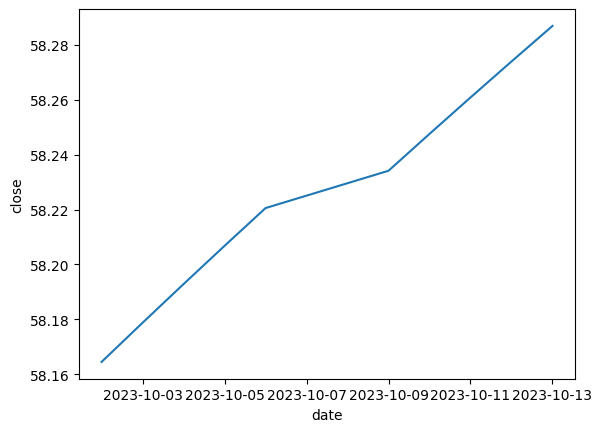

In [83]:
sns.lineplot(data=df_future,x='date',y='close')